In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
combine = [train_df, test_df]

# Visualisation

In [3]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are missing age values -> we need to fill them
There are 2 missing embarked values -> we need to fill them
Cabin values are mostly missing -> candidate for droppingv

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [7]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Chances of survival are somehow proportional to ticket class (the higher the class, the better)

In [8]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Females are much more likely to survive than males

In [9]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Number of family members also plays a role. To be investigated further. 

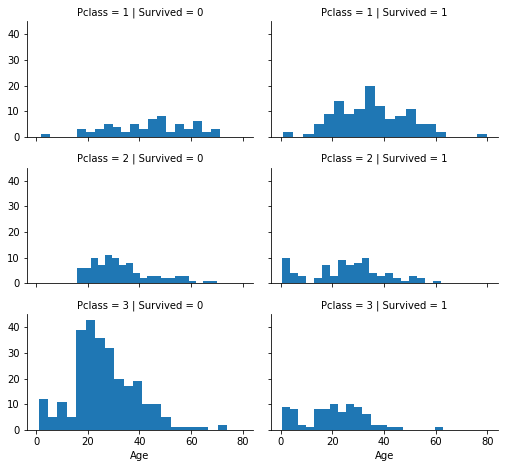

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

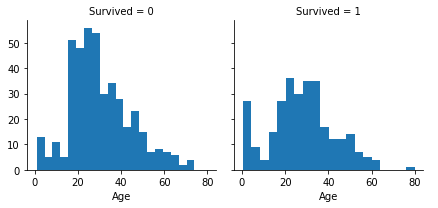

In [12]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)
g.add_legend()

# Wrangling

In [13]:
# Let's create an extra column, where we put how many others are travelling on the same ticket value

for dataset in combine:
    dataset['TicketCount'] = dataset.groupby('Ticket')['Ticket'].transform('count')

In [14]:
# Let's assign 1 if cabin is assigned, 0 otherwise
for dataset in combine:
    dataset['isCabin'] = np.where(dataset['Cabin'].isna(), 0, 1)

In [15]:
# Now we can drop ticket and cabin values

for dataset in combine:
    dataset.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

In [16]:
# Let's extract titles from the names

for dataset in combine:
    dataset['Title'] = dataset.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [17]:
# And combine the titles

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [18]:
# And transform them into numbers

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    # And drop names from the dataset
    dataset.drop(['Name'], axis=1, inplace=True)


In [19]:
# Drop the passenger id from the train dataset (we need it in the test one)

train_df.drop(['PassengerId'], axis=1, inplace=True)

In [20]:
# Map the gender with 1 and 0

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [21]:
# Fill the missing age values, grouped by sex, class and title

for dataset in combine:
    dataset['Age'] = dataset.groupby(['Sex', 'Pclass', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))

In [22]:
# Fill the missing fare value in the test set with the median

test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

In [23]:
# find the missing embarked values with the most common

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].value_counts().index[0])
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'Q': 1, 'C': 2} ).astype(int)

In [24]:
# Create family size value, adding SibSp and Parch

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [25]:
# Combine family size into family range, drop family size

for dataset in combine:
    dataset['FamilyRange'] = 0
    
    dataset.loc[dataset['FamilySize'] <= 1, 'FamilyRange'] = 0
    dataset.loc[(dataset['FamilySize'] > 1) & (dataset['FamilySize'] <= 4), 'FamilyRange'] = 1
    dataset.loc[(dataset['FamilySize'] > 4), 'FamilyRange'] = 2
    
    dataset.drop(['FamilySize'], axis=1, inplace=True)

train_df[['FamilyRange', 'Survived']].groupby(['FamilyRange'], as_index=False).mean()

,FamilyRange,Survived
0,0,0.303538
1,1,0.578767
2,2,0.161290


In [26]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TicketCount,isCabin,Title,FamilyRange
0,0,3,0,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,1,38.0,1,0,71.2833,2,1,1,2,1
2,1,3,1,26.0,0,0,7.9250,0,1,0,1,0
3,1,1,1,35.0,1,0,53.1000,0,2,1,2,1
4,0,3,0,35.0,0,0,8.0500,0,1,0,0,0


In [27]:
# create bands for the different fares

for dataset in combine:
    dataset['FareBand'] = 0
    dataset.loc[ dataset['Fare'] <= 7.91, 'FareBand'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'FareBand'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'FareBand']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'FareBand'] = 3
    dataset.drop(['Fare'], axis=1, inplace=True)

In [28]:
train_df['AgeBand'] = pd.qcut(train_df['Age'], 6)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.419, 18.0]",0.517045
1,"(18.0, 24.0]",0.357143
2,"(24.0, 26.0]",0.143939
3,"(26.0, 32.167]",0.424658
4,"(32.167, 40.833]",0.439189
5,"(40.833, 80.0]",0.369128


In [29]:
# create bands for the different ages

for dataset in combine:
    dataset['AgeBand'] = 0
    dataset.loc[ dataset['Age'] <= 18, 'AgeBand'] = 0
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 24), 'AgeBand'] = 1
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 26), 'AgeBand']   = 2
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 40), 'AgeBand']   = 3
    dataset.loc[ dataset['Age'] > 40, 'AgeBand'] = 4
    dataset.drop(['Age'], axis=1, inplace=True)

# Model, predict and solve

In [30]:
# prepare the datasets

X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

In [31]:
# Prepare the models we want to use

models = []

models += [('LogisticRegression', LogisticRegression(solver="lbfgs"))]
models += [('SVC', SVC(gamma='auto'))]
models += [('KNN', KNeighborsClassifier(n_neighbors = 3))]
models += [('GaussianNB', GaussianNB())]
#models += [('Perceptron', Perceptron(max_iter=1000, tol=0.01))]
#models += [('LinearSVC',  LinearSVC(max_iter=2000))]
models += [('SGD', SGDClassifier(max_iter=1000, tol=0.01,loss='log'))]
models += [('DecisionTree', DecisionTreeClassifier())]
models += [('RandomForest', RandomForestClassifier(n_estimators=100))]

accuracy = pd.DataFrame(columns=['Model', 'Score'])

In [32]:
# Run all the prediction on all models

for model in models:
    solver_name = model[0]
    solver = model[1]
    solver.fit(X_train, Y_train)
    Y_pred = solver.predict(X_test)
    score = solver.score(X_train, Y_train)
    acc = round(score * 100, 2)
    accuracy = accuracy.append({'Model' : solver_name , 'Score' : acc} , ignore_index=True)
    
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
    submission.to_csv('output/submission_' + solver_name + '.csv', index=False)

In [33]:
# Use a voting classifier to let different models vote

classifier = VotingClassifier(models, voting='hard')
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
score = classifier.score(X_train, Y_train)
acc = round(score * 100, 2)
accuracy = accuracy.append({'Model' : 'Classifier' , 'Score' : acc} , ignore_index=True)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": Y_pred
})
submission.to_csv('output/submission_classifier.csv', index=False)

In [34]:
# Rank the models based on accuracy

accuracy.sort_values(by='Score', ascending=False)

,Model,Score
5,DecisionTree,92.03
6,RandomForest,92.03
7,Classifier,87.32
2,KNN,86.98
1,SVC,84.18
0,LogisticRegression,82.04
4,SGD,79.57
3,GaussianNB,78.56
